In [1]:
from network import Model
from utils import *
from environment import Environment

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
from torch.distributions.categorical import Categorical
from tqdm import tqdm
from torch import nn

In [2]:
DEVICE = 'cpu'

In [3]:
class PPOTrainer():
  def __init__(self,
              actor_critic,
              ppo_clip_val=0.2,
              target_kl_div=0.01,
              max_policy_train_iters=80,
              value_train_iters=80,
              policy_lr=3e-4,
              value_lr=1e-2):
    self.ac = actor_critic
    self.ppo_clip_val = ppo_clip_val
    self.target_kl_div = target_kl_div
    self.max_policy_train_iters = max_policy_train_iters
    self.value_train_iters = value_train_iters

    policy_params = list(self.ac.shared_layers.parameters()) + list(self.ac.policy_layers.parameters())
    self.policy_optim = optim.Adam(policy_params, lr=policy_lr)

    value_params = list(self.ac.shared_layers.parameters()) + list(self.ac.value_layers.parameters())
    self.value_optim = optim.Adam(value_params, lr=value_lr)

  def train_policy(self, obs, acts, old_log_probs, gaes):
    for _ in range(self.max_policy_train_iters):
      self.policy_optim.zero_grad()
      logits = self.ac.policy(obs)
      # print(logits)
      dist = Categorical(logits=logits)
      # print(dist.probs)
      new_log_probs = dist.log_prob(acts)

      policy_ratio = torch.exp(new_log_probs - old_log_probs)
      if not torch.any(new_log_probs) and not torch.any(old_log_probs):
        print(new_log_probs, old_log_probs)
        print('ERROR')
      clipped_ratio = policy_ratio.clamp(1 - self.ppo_clip_val, 1 + self.ppo_clip_val)
      
      clipped_loss = clipped_ratio * gaes
      full_loss = policy_ratio * gaes
      policy_loss = -torch.min(full_loss, clipped_loss).mean()

      policy_loss.backward()
      self.policy_optim.step()

      kl_div = (old_log_probs - new_log_probs).mean()
      if kl_div >= self.target_kl_div:
        break

  def train_value(self, obs, returns):
    for _ in range(self.value_train_iters):
      self.value_optim.zero_grad()

      values = self.ac.value(obs)
      value_loss = (returns - values) ** 2
      value_loss = value_loss.mean()

      value_loss.backward()
      self.value_optim.step()

In [4]:
# Define training params
n_episodes = 10_000
print_freq = 20

model = Model(8, 91)
model.to(DEVICE)
# model.load_state_dict(torch.load('improving_model.pt'))
ppo = PPOTrainer(
    model,
    policy_lr = 3e-5,
    value_lr = 1e-4,
    target_kl_div = 0.01,
    max_policy_train_iters = 40,
    value_train_iters = 40)

In [5]:
model

Model(
  (shared_layers): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ReLU()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (policy_layers): Sequential(
    (0): Linear(in_features=128, out_features=91, bias=True)
  )
  (value_layers): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Tanh()
  )
)

In [9]:
# Training loop
ep_rewards = []
for episode_idx in range(n_episodes):
  env = Environment()
  # Perform rollout
  train_data, reward = rollout(model, env)
  ep_rewards.append(reward)

  # Shuffle
  permute_idxs = np.random.permutation(len(train_data[0]))

  # Policy data
  obs = torch.tensor(train_data[0][permute_idxs], dtype=torch.float32, device=DEVICE)
  acts = torch.tensor(train_data[1][permute_idxs], dtype=torch.float32, device=DEVICE)
  gaes = torch.tensor(train_data[3][permute_idxs], dtype=torch.float32, device=DEVICE)
  act_log_probs = torch.tensor(train_data[4][permute_idxs], dtype=torch.float32, device=DEVICE)

  # Value data
  returns = discount_rewards(train_data[2])[permute_idxs]
  returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)

  # Train model
  ppo.train_policy(obs, acts, act_log_probs, gaes)
  ppo.train_value(obs, returns)

  if (episode_idx + 1) % print_freq == 0:
    print('Episode {} | Avg Reward {:.1f}'.format(
        episode_idx + 1, np.mean(ep_rewards[-print_freq:])))

Episode 20 | Avg Reward -341.4
Episode 40 | Avg Reward -387.7
Episode 60 | Avg Reward -352.8
Episode 80 | Avg Reward -423.4
Episode 100 | Avg Reward -427.6
Episode 120 | Avg Reward -390.8
Episode 140 | Avg Reward -432.2
Episode 160 | Avg Reward -373.0
Episode 180 | Avg Reward -386.2
Episode 200 | Avg Reward -275.3
Episode 220 | Avg Reward -446.0
Episode 240 | Avg Reward -364.5
Episode 260 | Avg Reward -343.5
Episode 280 | Avg Reward -369.1
Episode 300 | Avg Reward -388.8
Episode 320 | Avg Reward -392.2
Episode 340 | Avg Reward -426.3
Episode 360 | Avg Reward -396.6
Episode 380 | Avg Reward -382.2
Episode 400 | Avg Reward -328.1
Episode 420 | Avg Reward -358.4
Episode 440 | Avg Reward -389.5
Episode 460 | Avg Reward -431.9
Episode 480 | Avg Reward -401.7
Episode 500 | Avg Reward -426.1
Episode 520 | Avg Reward -413.9
Episode 540 | Avg Reward -398.0
Episode 560 | Avg Reward -402.9
Episode 580 | Avg Reward -398.6
Episode 600 | Avg Reward -417.1
Episode 620 | Avg Reward -367.0
Episode 640 

KeyboardInterrupt: 

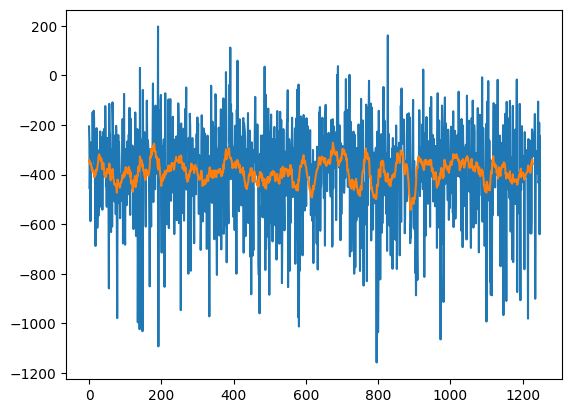

In [10]:
plt.plot(ep_rewards)
moving_avg = np.convolve(ep_rewards, np.ones(20)/20, mode='valid')
plt.plot(moving_avg)
plt.show()

In [12]:
for i in range(10):
    env = Environment()
    target, market, positions = rollout(model, env, 1000, True)
    print(f'TRIAL {i + 1} - TRUE VALUE: {target}')
    for j in range(len(market)):
        print(f'Step {j + 1} | Market: {market[j]} | Spread: {5 - j} | Net position: {positions[j]}')
    print()

TRIAL 1 - TRUE VALUE: 72
Step 1 | Market: 44 | Spread: 5 | Net position: 1
Step 2 | Market: 15 | Spread: 4 | Net position: 2
Step 3 | Market: 29 | Spread: 3 | Net position: 3
Step 4 | Market: 82 | Spread: 2 | Net position: 2
Step 5 | Market: 21 | Spread: 1 | Net position: 3

TRIAL 2 - TRUE VALUE: 35
Step 1 | Market: 62 | Spread: 5 | Net position: -1
Step 2 | Market: 32 | Spread: 4 | Net position: 0
Step 3 | Market: 15 | Spread: 3 | Net position: 1
Step 4 | Market: 32 | Spread: 2 | Net position: 2
Step 5 | Market: 64 | Spread: 1 | Net position: 1

TRIAL 3 - TRUE VALUE: 41
Step 1 | Market: 56 | Spread: 5 | Net position: -1
Step 2 | Market: 51 | Spread: 4 | Net position: -2
Step 3 | Market: 28 | Spread: 3 | Net position: -1
Step 4 | Market: 30 | Spread: 2 | Net position: 0
Step 5 | Market: 1 | Spread: 1 | Net position: 1

TRIAL 4 - TRUE VALUE: 44
Step 1 | Market: 85 | Spread: 5 | Net position: -1
Step 2 | Market: 56 | Spread: 4 | Net position: -2
Step 3 | Market: 12 | Spread: 3 | Net posi